## Neural Network training

In [ ]:
## Imports
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
import keras
import tensorflow_probability as tfp
import skfmm
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import matplotlib
import os
import glob
import math
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.model_selection import train_test_split
import itertools
import datetime
%load_ext tensorboard

In [26]:
## Load layered model
def load_model():
    path = 'Model_data\\real_01'
    data = pd.read_csv(path+'\layer_01_XYZ.txt', sep=";")
    data2 = pd.read_csv(path+'\layer_02_XYZ.txt', sep=";")
    data3 = pd.read_csv(path+'\layer_03_XYZ.txt', sep=";")
    data4 = pd.read_csv(path+'\layer_04_XYZ.txt', sep=";")
    data5 = pd.read_csv(path+'\layer_05_XYZ.txt', sep=";")
    data6 = pd.read_csv(path+'\layer_06_XYZ.txt', sep=";")
    data7 = pd.read_csv(path+'\layer_07_XYZ.txt', sep=";")
    data8 = pd.read_csv(path+'\layer_08_XYZ.txt', sep=";")
    data9 = pd.read_csv(path+'\layer_09_XYZ.txt', sep=";")
    data10 = pd.read_csv(path+'\layer_10_XYZ.txt', sep=";")
    data11 = pd.read_csv(path+'\layer_11_XYZ.txt', sep=";")
    data12 = pd.read_csv(path+'\layer_12_XYZ.txt', sep=";")
    data13 = pd.read_csv(path+'\layer_13_XYZ.txt', sep=";")
    data14 = pd.read_csv(path+'\layer_14_XYZ.txt', sep=";")
    data15 = pd.read_csv(path+'\layer_15_XYZ.txt', sep=";")
    lag1 = data.iloc[:,:-1]
    lag2 = data2.iloc[:,:-1]
    lag3 = data3.iloc[:,:-1]
    lag4 = data4.iloc[:,:-1]
    lag5 = data5.iloc[:,:-1]
    lag6 = data6.iloc[:,:-1]
    lag7 = data7.iloc[:,:-1]
    lag8 = data8.iloc[:,:-1]
    lag9 = data9.iloc[:,:-1]
    lag10 = data10.iloc[:,:-1]
    lag11 = data11.iloc[:,:-1]
    lag12 = data12.iloc[:,:-1]
    lag13 = data13.iloc[:,:-1]
    lag14 = data14.iloc[:,:-1]
    lag15 = data15.iloc[:,:-1]
    nLays=15
    nRows=144
    nCols=121
    zbot = np.zeros((nLays,nRows,nCols))
    zbot[0,:,:] = np.reshape(np.array(lag1['Z']),(144,121))
    zbot[1,:,:] = np.reshape(np.array(lag2['Z']),(144,121))
    zbot[2,:,:] = np.reshape(np.array(lag3['Z']),(144,121))
    zbot[3,:,:] = np.reshape(np.array(lag4['Z']),(144,121))
    zbot[4,:,:] = np.reshape(np.array(lag5['Z']),(144,121))
    zbot[5,:,:] = np.reshape(np.array(lag6['Z']),(144,121))
    zbot[6,:,:] = np.reshape(np.array(lag7['Z']),(144,121))
    zbot[7,:,:] = np.reshape(np.array(lag8['Z']),(144,121))
    zbot[8,:,:] = np.reshape(np.array(lag9['Z']),(144,121))
    zbot[9,:,:] = np.reshape(np.array(lag10['Z']),(144,121))
    zbot[10,:,:] = np.reshape(np.array(lag11['Z']),(144,121))
    zbot[11,:,:] = np.reshape(np.array(lag12['Z']),(144,121))
    zbot[12,:,:] = np.reshape(np.array(lag13['Z']),(144,121))
    zbot[13,:,:] = np.reshape(np.array(lag14['Z']),(144,121))
    zbot[14,:,:] = np.reshape(np.array(lag15['Z']),(144,121))
    return zbot

In [4]:
def well_distance(well_row,well_col):
    
        dx, dy = 100,100
        phi = np.ones((144,121))
        phi[well_row,well_col]=-1
        dist = skfmm.distance(phi,dx=[100,100])
        return dist

## Create Training data

In [12]:
## load model data
bound = np.loadtxt('Model_data\ibB.arr')
head0 = np.load('Model_data\data_deterministic\head_no_pump.npy')
dist_river = np.load('Model_data\dist_drain_riv.npy')
dist_ghb = np.load( 'Model_data\ghb_dist.npy')
conduc = np.load('Model_data\data_deterministic\conductivity.npy')
bound[bound==1]=np.nan

In [13]:
## Load simulated drawdown from Egebjerg model
nr_real = 1000
heads = np.ones((nr_real,14,144,121))
pump_rates = []
wells = []
files = []
for i in range(0,1000):
    file = glob.glob(os.path.join(f'Model_data\data_deterministic\head_real{i}_*.npy'))
    files.append(file)
    heads[i,:,:] = np.load(file[0])
    s = file[0].split('_')
    wells.append([int(s[-4]),int(s[-3]),int(s[-2])])
    s1 = s[-1].split('.')
    pump_rates.append(int(s1[0]))

 

In [28]:
## Load layers
layers = np.zeros((14,144,121))
layer = load_model()
layers=[np.flipud(layer[i,:,:]) for i in range(15)]
layers = np.array(layers)

In [30]:
## Assign hydraulic conductivity to all layers - This is a feature
rows_int = []
cols_int = []
hyd = []
QS_cond = 20
QC_cond = 0.01
MIOC_cond = 0.01
MIOS_cond = 10
PALC_cond = 0.01
CHALK_cond = 0.1


low=1
high=1
cond = [0,QS_cond*np.random.uniform(low=low, high=high),QC_cond,QS_cond*np.random.uniform(low=low, high=high),QC_cond,QS_cond*np.random.uniform(low=low, high=high),QC_cond,QS_cond*np.random.uniform(low=low, high=high),QC_cond,QS_cond*np.random.uniform(low=low, high=high),MIOC_cond,MIOS_cond,MIOC_cond,PALC_cond,CHALK_cond]

for k in range(15):
    for i in tqdm(range(144)):
        for j in range(121):
            rows_int.append(i)
            cols_int.append(j)
            hyd.append(cond[k])

100%|█████████████████████████████████████████████████████████████████████████████| 144/144 [00:00<00:00, 24001.74it/s]


In [31]:
## set up rows and columns - and find the conductivities of the top active layer cells
rows = []
cols = []
for i in tqdm(range(144)):
    for j in range(121):
        rows.append(i)
        cols.append(j)
        

top_layer = np.zeros((144,121))*np.nan
for i in range(144):
    for j in range(121):
        for k in range(14):
            if math.isnan(head0[k,i,j]) == False:
                top_layer[i,j] = cond[k+1]
                break
top_layer = np.nan_to_num(top_layer)
top_layer  

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [33]:
## Collect input features to training
head_change = []
head_no_pump = []
well_dist = []
times = []
river_dist = []
ghb_dist = []
cond = []
log_cond = []
pump_rate = []
layer = []
well_layer = []
well_row = []
well_col = []
row_nr = []
col_nr = []
for j in tqdm(range(0,1000)):
    phi =  np.ones_like(top_layer)*-1
    phi[wells[j][1],wells[j][2]]=1
    ts = skfmm.travel_time(phi, top_layer,dx=100)
    for i in range(14):
        head_change.append(list(heads[j,i].flatten()))
        head_no_pump.append(list(head0[i].flatten()))
        well_dist.append(list(well_distance(wells[j][1],wells[j][2]).flatten()))
        
        times.append(list(ts.data.flatten()))     

        river_dist.append(list(dist_river.flatten()))
        ghb_dist.append(list(dist_ghb.flatten()))
        cond.append(list(conduc[i].flatten()))
        log_cond.append(list(np.log10(conduc[i]).flatten()))
        pump_rate.append(list(np.ones(144*121)*pump_rates[j]))
        layer.append(list(np.ones(144*121)*i))  
        well_layer.append(list(np.ones(144*121)*wells[j][0]))
        well_row.append(list(np.ones(144*121)*wells[j][1]))
        well_col.append(list(np.ones(144*121)*wells[j][2]))
        row_nr.append(list(rows))
        col_nr.append(list(cols))
        

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.27it/s]


In [34]:
head_change = list(itertools.chain(*head_change))
head_no_pump = list(itertools.chain(*head_no_pump))
well_dist = list(itertools.chain(*well_dist))
times = list(itertools.chain(*times))
river_dist = list(itertools.chain(*river_dist))
ghb_dist = list(itertools.chain(*ghb_dist))
cond = list(itertools.chain(*cond))
log_cond = list(itertools.chain(*log_cond))
pump_rate = list(itertools.chain(*pump_rate))
layer = list(itertools.chain(*layer))
well_layer = list(itertools.chain(*well_layer))
well_row = list(itertools.chain(*well_row))
well_col = list(itertools.chain(*well_col))
row_nr = list(itertools.chain(*row_nr))
col_nr = list(itertools.chain(*col_nr))

In [35]:
## Remove entries that are Nan
indices = [i for i, x in enumerate(head_change) if math.isnan(x)==False]

In [36]:
## construct dataframe with all data
columns = ['head_change','head_no_pump','well_dist','travel_times','river_dist','ghb_dist','cond','log_cond','pump_rate','layer','well_layer','well_row','well_col','row_nr','col_nr']
dfs = pd.DataFrame(data = np.transpose([np.array(head_change)[indices],np.array(head_no_pump)[indices],np.array(well_dist)[indices],np.array(times)[indices],np.array(river_dist)[indices],np.array(ghb_dist)[indices],np.array(cond)[indices],np.array(log_cond)[indices],np.array(pump_rate)[indices],np.array(layer)[indices],np.array(well_layer)[indices],np.array(well_row)[indices],np.array(well_col)[indices],np.array(row_nr)[indices],np.array(col_nr)[indices]]),columns = columns)

In [37]:
## sampling from dataframe to remove some low drawdown values
df = pd.concat([dfs[dfs['head_change'] <= 0.1].sample(frac = 0.01),dfs[(dfs['head_change'] > 0.1) & (dfs['head_change'] <= .5)].sample(frac = 0.1),dfs[dfs['head_change']>0.5].sample(frac=1)])

In [39]:
df

,head_change,head_no_pump,well_dist,travel_times,river_dist,ghb_dist,cond,log_cond,pump_rate,layer,well_layer,well_row,well_col,row_nr,col_nr
878485,0.002473,1.873875,9472.394497,485077.033945,2042.677670,-50.000000,0.01,-2.00000,3387.0,7.0,6.0,66.0,58.0,142.0,115.0
966278,0.002896,4.895089,11642.884605,390814.130463,3188.170828,366.965916,0.01,-2.00000,2187.0,5.0,6.0,33.0,34.0,138.0,85.0
362953,0.008944,2.316834,7946.862471,182412.442328,395.834612,180.134076,20.00,1.30103,3234.0,6.0,6.0,47.0,84.0,116.0,44.0
58970,0.015000,49.012467,9140.235945,146782.223941,2266.318861,10972.984962,0.01,-2.00000,761.0,7.0,6.0,92.0,44.0,9.0,83.0
34723,0.011004,35.357756,2957.256356,116413.662546,719.135849,5552.393193,20.00,1.30103,761.0,4.0,6.0,92.0,44.0,62.0,42.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
926357,1.241993,50.470553,2613.798867,16117.050939,464.043457,9950.675791,20.00,1.30103,2187.0,2.0,6.0,33.0,34.0,17.0,55.0
837027,0.669356,46.656813,5697.600600,289058.031250,1839.813272,6342.677670,0.01,-2.00000,3387.0,3.0,6.0,66.0,58.0,59.0,115.0
182809,0.922450,42.778738,1677.452820,81514.592711,906.841898,6561.529842,0.01,-2.00000,2141.0,12.0,8.0,37.0,74.0,53.0,80.0
916443,0.875921,50.800009,4824.206288,16337.759595,2143.846092,9368.750733,20.00,1.30103,2187.0,0.0,6.0,33.0,34.0,25.0,82.0


In [40]:
## Clear values
head_change = []
head_no_pump = []
well_dist = []
times = []
river_dist = []
ghb_dist = []
cond = []
log_cond = []
pump_rate = []
layer = []
well_layer = []
well_row = []
well_col = []
row_nr = []
col_nr = []

In [41]:
## Data split to train and validation sets
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,1:-2], df.iloc[:,0], test_size=0.2)

In [42]:
## Standard scaling the data
scaler = StandardScaler()
scaler.fit(X_train) 
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test) 

In [43]:
## Constructing the nerual network 
tfd = tfp.distributions

negloglik = lambda y, p_y: -p_y.log_prob(y)

Inputs = Input(shape = (12,))

layer1 = Dense(75,activation = 'gelu')(Inputs)
layer2 = Dense(75,activation = 'gelu')(layer1)
layer3 = Dense(75,activation = 'gelu')(layer2)
layer4 = Dense(1+1,activation = 'linear')(layer3)
output =  tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t[..., :1], scale=1e-3 + tf.math.softplus(0.05 * t[..., 1:])))(layer4)

model = Model(inputs = Inputs, outputs = output)

In [44]:
## Compile. This will also run tensorboard to visualise training phase
model.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.001), loss = negloglik)
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
%tensorboard --logdir logs/fit
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 12)]              0         
                                                                 
 dense (Dense)               (None, 75)                975       
                                                                 
 dense_1 (Dense)             (None, 75)                5700      
                                                                 
 dense_2 (Dense)             (None, 75)                5700      
                                                                 
 dense_3 (Dense)             (None, 2)                 152       
                                                                 
 distribution_lambda (Distri  ((None, 1),              0         
 butionLambda)                (None, 1))                         
                                                             

In [45]:
## Train the network
results = model.fit(X_train,y_train,batch_size = 10000, epochs = 1000, validation_data = (X_test,y_test),callbacks=[tensorboard_callback])

Epoch 1/10
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
33/33 [==============================] - 1s 24ms/step - loss: 0.9830 - val_loss: 0.6318
Epoch 2/10
33/33 [==============================] - 1s 18ms/step - loss: 0.5918 - val_loss: 0.5647
Epoch 3/10
33/33 [==============================] - 1s 18ms/step - loss: 0.5437 - val_loss: 0.5187
Epoch 4/10
33/33 [==============================] - 1s 18ms/step - loss: 0.4581 - val_loss: 0.3412
Epoch 5/10
33/33 [==============================] - 1s 18ms/step - loss: 0.0187 - val_loss: -0.3491
Epoch 6/10
33/33 [==============================] - 1s 18ms/step - loss: -0.4453 - val_loss: -0.6150
Epoch 7/10
33/33 [==============================] - 1s 18ms/step - loss: -0.6816 - val_loss: -0.7715
Epoch 8/10
33/33 [==============================] - 1s 18ms/step - loss: -0.6928 - val_loss: -0.7732


In [ ]:
## Save the trained network
model.save(f"trained_network.h5")

In [ ]:
## Save the scaler
import joblib
joblib.dump(scaler, 'scaler.bin', compress=True)

## Testing the network

In [46]:
## Test the trained network
y_hat = model(X_test)
mean = y_hat.mean()
stddev = y_hat.stddev()

(0.0, 20.0, 0.0, 20.0)

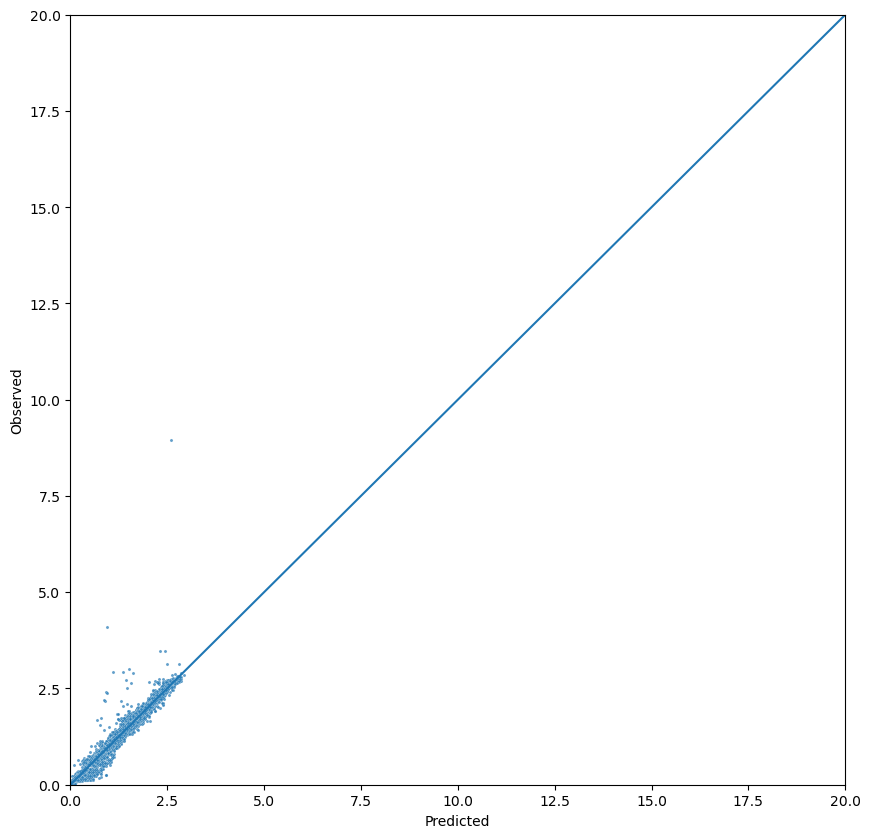

In [48]:
import seaborn as sns
fig = plt.figure(figsize=(10, 10))
sns.scatterplot(x=mean[::10,0], y=y_test[::10],alpha=0.7,s=5)
plt.plot([10**(-7),10**2],[10**(-7),10**2],'-')
plt.ylabel('Observed')
plt.xlabel('Predicted')
plt.axis([0,20,0,20])